In [1]:
#Data Handling
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.applications import ResNet101V2

#TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as lyrs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

#Global Variables
root="C:/Users/AISW-203-109/Downloads/archive/flower_images"
IMG_SIZE=224

In [4]:
#View Random Image
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)
    
#Pre-processing the Image
def pre_process_image(path, image_shape=224, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

#Testing Image Classification Model
def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))
    
    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)
    
    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path)) 
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]
        
    '''Visualize'''
    plt.imshow(random_image)
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder)
    plt.show()
    
#Plot Loss and Accuracy curve for the given Model
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]
    
    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
#Confusion Matrix for Classification
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

#Supervised Learning Meterics
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

In [5]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="training",
    seed=42,
)

test_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 4000 images belonging to 6 classes.
Found 1000 images belonging to 6 classes.


In [9]:
#Import MobileNetV2 Model
model_base = ResNet101V2(
    input_shape=(224,224,3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

#Transfer Learning Model
inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.Dropout(0.5)(x)
outputs=lyrs.Dense(6, activation="softmax", 
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101v2 (Functional)        │ (None, 7, 7, 2048)     │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,638,854 (162.65 MB)

 Trainable params: 14,455,814 (55.14 MB)

 Non-trainable params: 28,183,040 (107.51 MB)

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

checkpointer = ModelCheckpoint('flower_image.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 옵티마이저 초기화 시 learning_rate 사용
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

model_history = model.fit(x=train_datagen, 
                          steps_per_epoch=32,
                          validation_data=test_datagen,
                          epochs=10,
                          callbacks=[checkpointer, early_stopping])

model_save_path = 'C:/Users/AISW-203-109/tkinter_0628/images/saved_model.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Epoch 1/10


C:\Users\AISW-203-109\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4301 - loss: 1.4883
Epoch 1: val_loss improved from inf to 0.69343, saving model to flower_image.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.4348 - loss: 1.4767 - val_accuracy: 0.7750 - val_loss: 0.6934
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8266 - loss: 0.5344
Epoch 2: val_loss improved from 0.69343 to 0.38171, saving model to flower_image.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.8272 - loss: 0.5324 - val_accuracy: 0.8870 - val_loss: 0.3817
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9288 - loss: 0.2746
Epoch 3: val_loss improved from 0.38171 to 0.28599, saving model to flower_image.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.9289 - loss: 0.2738 - val_accuracy: 0.9160 - val_loss: 0.2860
Epoch 4/10
29/32 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9375 - loss: 0.1984

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 4: val_loss improved from 0.28599 to 0.26997, saving model to flower_image.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9384 - loss: 0.1966 - val_accuracy: 0.9310 - val_loss: 0.2700
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9517 - loss: 0.1755
Epoch 5: val_loss improved from 0.26997 to 0.23816, saving model to flower_image.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9518 - loss: 0.1752 - val_accuracy: 0.9340 - val_loss: 0.2382
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9711 - loss: 0.1273
Epoch 6: val_loss improved from 0.23816 to 0.21107, saving model to flower_image.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.9709 - loss: 0.1277 - val_accuracy: 0.9460 - val_loss: 0.2111
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9743 - loss: 0.1049
Epoch 7: val_loss improved from 0.21107 to 0.18251, saving model to flower_image.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.

Model saved at: C:/Users/AISW-203-109/tkinter_0628/images/saved_model.h5


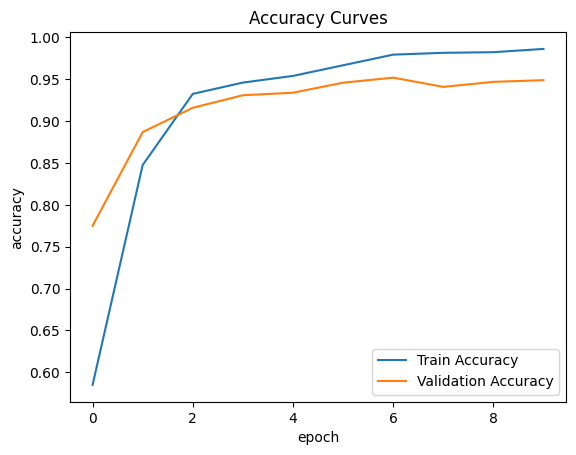

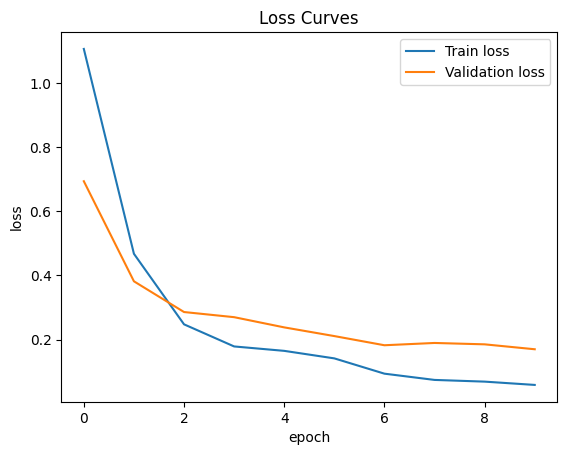

In [11]:
loss_curve_plot(model_history)

In [12]:
labels=test_datagen.classes
model_path = r"C:\Users\AISW-203-109\Pictures\flower_sample.h5"
y_pred=model.predict(test_datagen)
prediction=tf.math.round(y_pred).numpy()
prediction=prediction.argmax(axis=1)

supervised_metrics(labels, prediction)

# 예측 결과 출력
print(f"Predicted class: {prediction}")



32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
Accuracy : 94.8 %
F1 Score : 0.9481472015087158
Recall : 0.948
Precision : 0.9487393605772698
Predicted class: [0 0 0 0 4 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 4 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 4 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2
 1 4 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

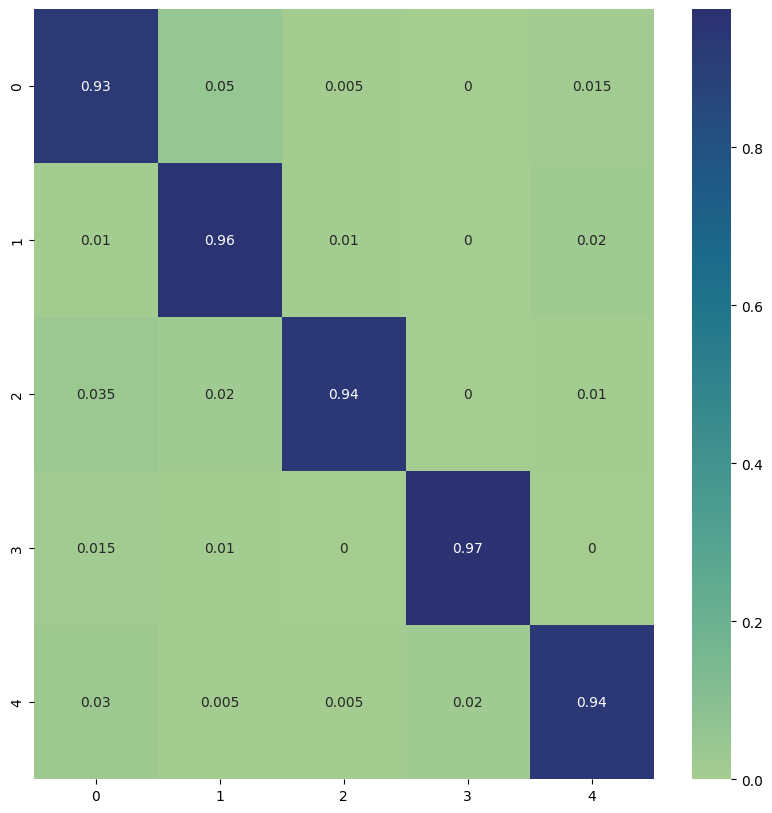

In [13]:
confusion_matrix_plot(labels, prediction, figsize=(10,10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


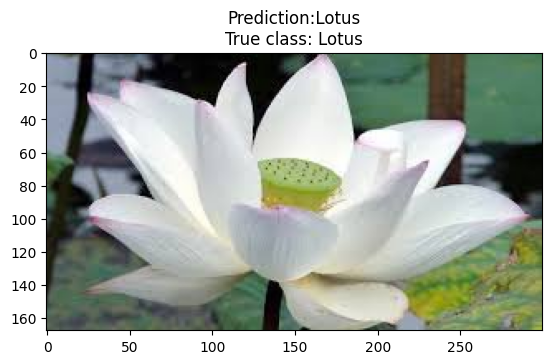

In [14]:
random_tester(root, ["Lilly", "Lotus", "Orchid", "Sunflower", "Tulip"], model, class_type="multi")